<a href="https://colab.research.google.com/github/Theivaprakasham/speechrecognition/blob/main/Jasper/JASPER_10x5_Test_Inference_Librispeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Jasper: An End-to-End Convolutional Neural Acoustic Model**

Jasper (Just Another Speech Recognizer) is a deep time delay neural network (TDNN) comprising of blocks of 1D-convolutional layers. Jasper is a family of models where each model has a different number of layers. Jasper models are denoted as Jasper bxr where b and r represent:

    b: the number of blocks
    r: the number of repetitions of each convolutional layer within a block


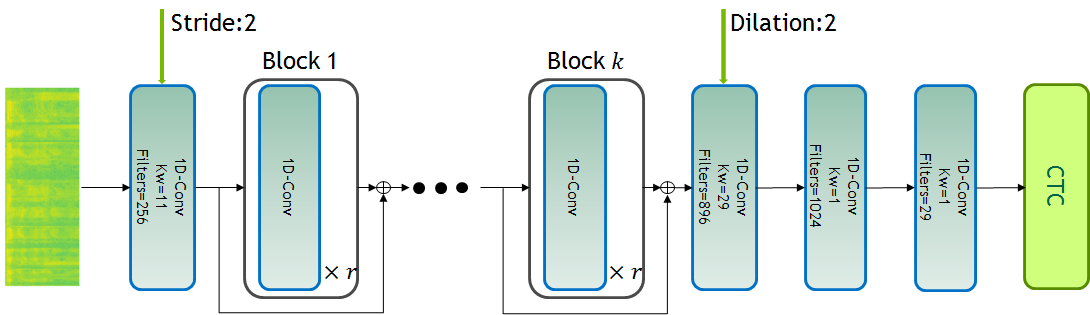


All models have 4 common layers. There is an initial convolutional layer with stride 2 to decrease the time dimension of the speech. The other 3 layers are at the end of the network. The first layer has a dilation of 2 to increase the model’s receptive field. The last two layers are fully connected layers that are used to project the final output to a distribution over characters.

Each 1D-convolutional layer consists of a convolutional operation, batch normalization, clipped relu activation, and dropout. Shown on the left.

There is a residual connection between each block which consists of a projection layer, followed by batch normalization. The residual is then added to the output of the last 1D-convolutional layer in the block before the clipped relu activation and dropout. Shown on the right.


**Experiments carried out by: Darshana S and Theivaprakasham H**

In [ ]:
!nvidia-smi

Sun Nov 21 15:10:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

# Installing OpenSeq2Seq dependencies and downloading Pre-trained JASPER Model

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/NVIDIA/OpenSeq2Seq.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q --depth 1 {git_repo_url}
  !git checkout e958b7d
  !pip uninstall -y -q pymc3
  !pip install --upgrade joblib
  #!cd {project_name} && pip install -q -r requirements.txt
  !pip install -q youtube-dl librosa python_speech_features sentencepiece
  
  # create eval config
  !cp {project_name}/example_configs/speech2text/jasper10x5_LibriSpeech_nvgrad.py {project_name}/conf.py
  !sed -i -e 's/\/data\/librispeech\/librivox-test-clean/test/' {project_name}/conf.py
  #!sed -i -e 's/# "use_lang/"use_lang/' {project_name}/conf.py
  !echo 'backend = "librosa"' >> {project_name}/conf.py 
  #!cat {project_name}/conf.py
  !echo "wav_filename, wav_filesize, transcript" > {project_name}/test.csv
  !echo "test.wav, UNUSED, UNUSED" >> {project_name}/test.csv
  
import sys
sys.path.append(project_name)

!pip install sox
!sudo apt-get install sox libsox-fmt-mp3


def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}
  
if not exists(join(project_name, 'w2l_log_folder')):
  download_from_google_drive('1gzGT8HoVNKY1i5HNQTKaSoCu7JHV4siR', 'jasper_10x5_dr_sp_nvgrad.zip')
  !unzip jasper_10x5_dr_sp_nvgrad.zip
  !mv checkpoint {project_name}/jasper_log_folder

%tensorflow_version 1.x

import os
os._exit(00)

fatal: not a git repository (or any of the parent directories): .git
     |████████████████████████████████| 1.9 MB 4.0 MB/s 
     |████████████████████████████████| 1.2 MB 62.1 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libid3tag0 libmad0 libmagic-mgc libmagic1 libopencore-amrnb0
  libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libid3tag0 libmad0 libmagic-mgc libmagic1 libopencore-amrnb0
  libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox-fmt-mp3 libsox3
  sox
0 upgraded, 11 newly installed, 0 to remove and 37 not upgraded.
Need to get 872 kB of archives.
After this operation, 7,087 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://archive.ubuntu.com/ubunt

In [1]:
!pip install datasets
!apt install git-lfs
!pip install jiwer

!pip install pandas sentencepiece
!pip install sox
!sudo apt-get install sox libsox-fmt-mp3

     |████████████████████████████████| 290 kB 4.1 MB/s 
     |████████████████████████████████| 243 kB 74.1 MB/s 
     |████████████████████████████████| 132 kB 87.5 MB/s 
     |████████████████████████████████| 59 kB 8.0 MB/s 
     |████████████████████████████████| 1.1 MB 72.3 MB/s 
     |████████████████████████████████| 271 kB 69.6 MB/s 
     |████████████████████████████████| 160 kB 71.2 MB/s 
     |████████████████████████████████| 192 kB 70.1 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 2s (901 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 155332 files and dir

# Loading Test Data from Librispeech clean Corpus

In [ ]:
import os
from os.path import exists, join, basename, splitext
import sys

In [2]:
#Load Test clean data of LibriSpeech Dataset
from datasets import load_dataset, load_metric
librispeech_eval = load_dataset("librispeech_asr", "clean", split="test")  # change to "other" for other test dataset
wer = load_metric("wer")

Downloading:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/338M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.39G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0G [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset librispeech_asr downloaded and prepared to /root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/f58a17d82b157feddbc407342a657fee7389b87c33d8331312edf7a604392896. Subsequent calls will reuse this data.


Downloading:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

In [13]:
import soundfile as sf
from pathlib import Path
import glob, shutil

data = librispeech_eval['file']

In [31]:
import os
os.makedirs('/content/test_files', exist_ok=True)

In [55]:
#Using Multi-processing to Convert FLAC files to WAV files sampled at 16kHz

from concurrent.futures import ThreadPoolExecutor
import numpy as np
from time import sleep


def convert_audio(n):
  os.system(f"ffmpeg -loglevel panic -y -i {n} -acodec pcm_s16le -ac 1 -ar 16000 '/content/test_files/{Path(n).stem}.wav'")
  print(f"/n Converted {n}")

In [56]:
with ThreadPoolExecutor(max_workers = 4) as executor:
  thread1 = executor.map(convert_audio, librispeech_eval['file'])

/n Converted /root/.cache/huggingface/datasets/downloads/extracted/e0f3d50e856945385982ba36b58615b72eef9b2ba5a2565bdcc225b70f495eed/LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac
/n Converted /root/.cache/huggingface/datasets/downloads/extracted/e0f3d50e856945385982ba36b58615b72eef9b2ba5a2565bdcc225b70f495eed/LibriSpeech/test-clean/1089/134686/1089-134686-0001.flac
/n Converted /root/.cache/huggingface/datasets/downloads/extracted/e0f3d50e856945385982ba36b58615b72eef9b2ba5a2565bdcc225b70f495eed/LibriSpeech/test-clean/1089/134686/1089-134686-0002.flac
/n Converted /root/.cache/huggingface/datasets/downloads/extracted/e0f3d50e856945385982ba36b58615b72eef9b2ba5a2565bdcc225b70f495eed/LibriSpeech/test-clean/1089/134686/1089-134686-0003.flac
/n Converted /root/.cache/huggingface/datasets/downloads/extracted/e0f3d50e856945385982ba36b58615b72eef9b2ba5a2565bdcc225b70f495eed/LibriSpeech/test-clean/1089/134686/1089-134686-0004.flac
/n Converted /root/.cache/huggingface/datasets/download

In [60]:
test_file_paths = sorted(glob.glob('/content/test_files/*'))
labels_truth = librispeech_eval['text']

dummy_labels=[]
for _ in range(0,len(test_file_paths)): dummy_labels.append("UNUSED")

In [96]:
import pandas as pd
df = pd.DataFrame()

In [97]:
df['wav_filename'] = test_file_paths
df['wav_filesize'] = dummy_labels
df['transcript'] = dummy_labels

df.to_csv('/content/OpenSeq2Seq/test.csv')

In [75]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# JASPER model Inference on Test Data

In [98]:
%%time
!cd "/content/OpenSeq2Seq" && python run.py --config_file conf.py --mode=infer --infer_output_file=output.txt --use_horovod=False --num_gpus=1 --batch_size_per_gpu 1












The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



*** Restoring from the latest checkpoint
*** Loading model from jasper_log_folder/model.ckpt-439200
*** Inference config:
{'batch_size_per_gpu': 1,
 'data_layer': <class 'open_seq2seq.data.speech2text.speech2text.Speech2TextDataLayer'>,
 'data_layer_params': {'backend': 'librosa',
                       'dataset_files': ['test.csv'],
                       'dither': 1e-05,
                       'input_type': 'logfbank',
                       'norm_per_feature': True,
                       'num_audio_features': 64,
                       'pad_to': 16,
                       'precompute_mel_basis': True,
          

In [99]:
predicted = pd.read_csv("/content/OpenSeq2Seq/output.txt")['predicted_transcript'].to_list()

In [100]:
predicted[0:5]

['he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flower fattened sauce',
 'stuff it into you his belly counselled him',
 'after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels',
 'hello berty any good in your mind',
 'number ten fresh nellie is waiting on you good night husband']

In [101]:
label_truth_samples = []

for i in range(len(labels_truth)):
  label_truth_samples.append(labels_truth[i].lower())

In [103]:
label_truth_samples[0:5]

['he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce',
 'stuff it into you his belly counselled him',
 'after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels',
 'hello bertie any good in your mind',
 'number ten fresh nelly is waiting on you good night husband']

In [104]:
print("WER:", wer.compute(predictions=predicted, references=label_truth_samples))

WER: 0.0386488131466829


# JASPER model Inference on 10 sample Test Data

In [73]:
import pandas as pd
df = pd.DataFrame()

df['wav_filename'] = test_file_paths[0:10]
df['wav_filesize'] = dummy_labels[0:10]
df['transcript'] = dummy_labels[0:10]

df.to_csv('/content/OpenSeq2Seq/test.csv')

In [76]:
%%time
!cd "/content/OpenSeq2Seq" && python run.py --config_file conf.py --mode=infer --infer_output_file=output.txt --use_horovod=False --num_gpus=1 --batch_size_per_gpu 1












The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



*** Restoring from the latest checkpoint
*** Loading model from jasper_log_folder/model.ckpt-439200
*** Inference config:
{'batch_size_per_gpu': 1,
 'data_layer': <class 'open_seq2seq.data.speech2text.speech2text.Speech2TextDataLayer'>,
 'data_layer_params': {'backend': 'librosa',
                       'dataset_files': ['test.csv'],
                       'dither': 1e-05,
                       'input_type': 'logfbank',
                       'norm_per_feature': True,
                       'num_audio_features': 64,
                       'pad_to': 16,
                       'precompute_mel_basis': True,
          

In [77]:
!cat /content/OpenSeq2Seq/output.txt

wav_filename,predicted_transcript
/content/test_files/1089-134686-0000.wav,he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flower fattened sauce
/content/test_files/1089-134686-0001.wav,stuff it into you his belly counselled him
/content/test_files/1089-134686-0002.wav,after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels
/content/test_files/1089-134686-0003.wav,hello berty any good in your mind
/content/test_files/1089-134686-0004.wav,number ten fresh nellie is waiting on you good night husband
/content/test_files/1089-134686-0005.wav,the music came nearer and he recalled the words the words of shelley's fragment upon the moon wandering companionless pale for weariness
/content/test_files/1089-134686-0006.wav,the dull light fell more faintly upon the page whereon another equation began to unfold itself slowly and to spread abroad its widening tai

In [87]:
predicted = pd.read_csv("/content/OpenSeq2Seq/output.txt")['predicted_transcript'].to_list()

In [88]:
labels_truth[0:10]

['HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE',
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 'AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT UP HERE AND THERE THE SQUALID QUARTER OF THE BROTHELS',
 'HELLO BERTIE ANY GOOD IN YOUR MIND',
 'NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD NIGHT HUSBAND',
 "THE MUSIC CAME NEARER AND HE RECALLED THE WORDS THE WORDS OF SHELLEY'S FRAGMENT UPON THE MOON WANDERING COMPANIONLESS PALE FOR WEARINESS",
 'THE DULL LIGHT FELL MORE FAINTLY UPON THE PAGE WHEREON ANOTHER EQUATION BEGAN TO UNFOLD ITSELF SLOWLY AND TO SPREAD ABROAD ITS WIDENING TAIL',
 'A COLD LUCID INDIFFERENCE REIGNED IN HIS SOUL',
 'THE CHAOS IN WHICH HIS ARDOUR EXTINGUISHED ITSELF WAS A COLD INDIFFERENT KNOWLEDGE OF HIMSELF',
 'AT MOST BY AN ALMS GIVEN TO A BEGGAR WHOSE BLESSING HE FLED FROM HE MIGHT HOPE WEARILY TO WIN FOR HIMSELF SOME MEASURE OF ACTUAL GRACE']

In [91]:
label_truth_10_samples = []

for i in range(len(labels_truth[0:10])):
  label_truth_10_samples.append(labels_truth[i].lower())

In [92]:
label_truth_10_samples

['he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce',
 'stuff it into you his belly counselled him',
 'after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels',
 'hello bertie any good in your mind',
 'number ten fresh nelly is waiting on you good night husband',
 "the music came nearer and he recalled the words the words of shelley's fragment upon the moon wandering companionless pale for weariness",
 'the dull light fell more faintly upon the page whereon another equation began to unfold itself slowly and to spread abroad its widening tail',
 'a cold lucid indifference reigned in his soul',
 'the chaos in which his ardour extinguished itself was a cold indifferent knowledge of himself',
 'at most by an alms given to a beggar whose blessing he fled from he might hope wearily to win for himself some measure of actual grace']

In [93]:
predicted

['he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flower fattened sauce',
 'stuff it into you his belly counselled him',
 'after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels',
 'hello berty any good in your mind',
 'number ten fresh nellie is waiting on you good night husband',
 "the music came nearer and he recalled the words the words of shelley's fragment upon the moon wandering companionless pale for weariness",
 'the dull light fell more faintly upon the page whereon another equation began to unfold itself slowly and to spread abroad its widening tail',
 'a cold lucid indifference reigned in his soul',
 'the chaos in which his ardour extinguished itself was a cold indifferent knowledge of himself',
 'at most by an alms given to a beggar whose blessing he fled from he might hope wearily to win for himself some measure of actual grace']

In [95]:
print("WER:", wer.compute(predictions=predicted, references=label_truth_10_samples))

WER: 0.017857142857142856


# Requirements

In [106]:
!pip freeze

absl-py==0.12.0
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argcomplete==1.12.3
argon2-cffi==21.1.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.1
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
bz2file==0.98
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.1.1
chardet==3.0.4
charset-normalizer==2.0.7
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cy

In [107]:
!pip freeze > requirements.txt

# References

1.  Li, Jason et al. “Jasper: An End-to-End Convolutional Neural Acoustic Model.” ArXiv abs/1904.03288 (2019) [Article Link](https://arxiv.org/pdf/1904.03288.pdf)
2.   Official Documentation of OpenSeq2Seq [Original Code](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/jasper.html)

3. Google Colab Implementation of JASPER [Colab Notebook](https://colab.research.google.com/github/tugstugi/dl-colab-notebooks/blob/master/notebooks/NVidiaJasper.ipynb
)
